In [41]:
import torch
import torchvision
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F
from torchvision.datasets import MNIST
from torchvision.transforms import ToTensor
from torchvision.utils import make_grid
from torch.utils.data.dataloader import DataLoader
from torch.utils.data import random_split
%matplotlib inline

# Use a white background for matplotlib figures
matplotlib.rcParams['figure.facecolor'] = '#ffffff'


In [42]:
dataset = MNIST(root='data/',download=True,transform=ToTensor())

image.shape: torch.Size([1, 28, 28])
Label: 5


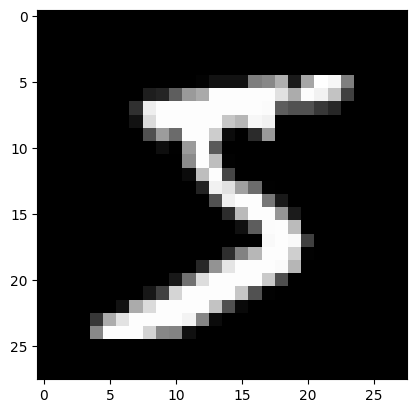

In [43]:
image , label = dataset[0]
print('image.shape:',image.shape)
plt.imshow(image[0],cmap='gray')
print('Label:',label)   

In [44]:
val_size = 10000
train_size = len(dataset) - val_size

train_ds , val_ds = random_split(dataset,[train_size,val_size])
len(train_ds),len(val_ds)

(50000, 10000)

In [45]:
batch_size = 128

In [46]:
train_loader = DataLoader(train_ds,batch_size ,shuffle=True,num_workers=4,pin_memory=True)
val_loader = DataLoader(val_ds,batch_size*2 , num_workers=4,pin_memory=True)

images.shape: torch.Size([128, 1, 28, 28])


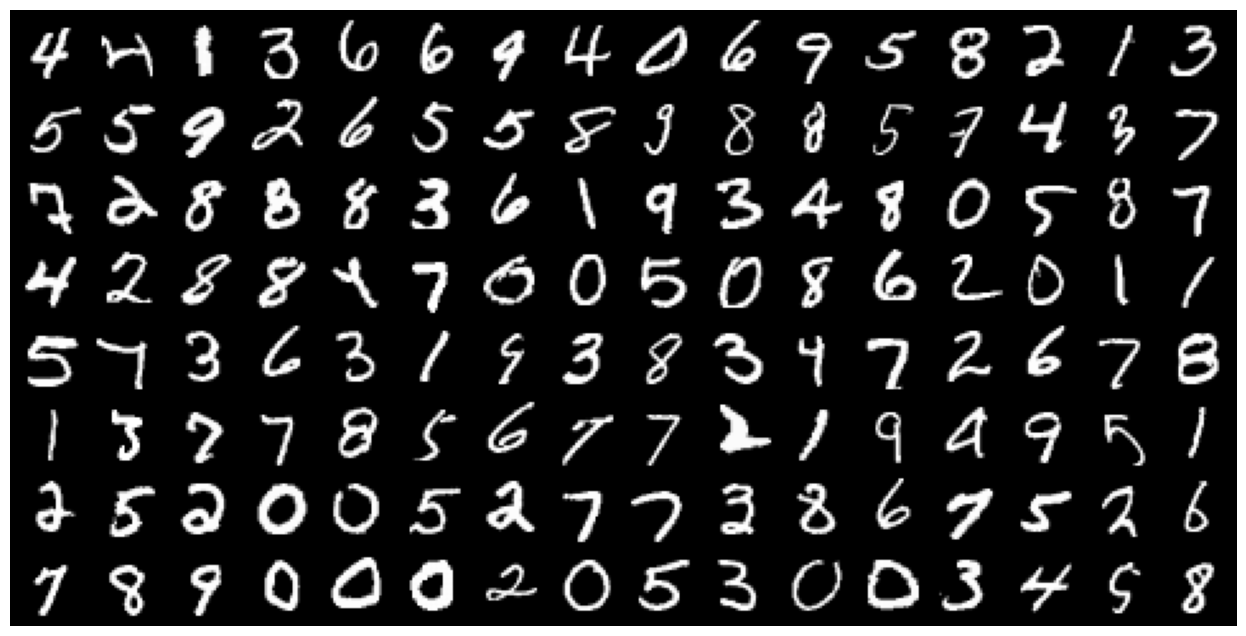

In [47]:
for images, _ in train_loader:
    print('images.shape:', images.shape)
    plt.figure(figsize=(16,8))
    plt.axis('off')
    plt.imshow(make_grid(images, nrow=16).permute((1, 2, 0)))
    break

In [48]:
for images , labels in train_loader:
    print('images.shape:',images.shape)
    inputs = images.reshape(-1,784)
    print('input.shape',inputs.shape)
    break

images.shape: torch.Size([128, 1, 28, 28])
input.shape torch.Size([128, 784])


In [49]:
input_size = inputs.shape[-1]
hidden_size = 32

In [50]:
layer1 = nn.Linear(input_size,hidden_size)

In [51]:
inputs.shape

torch.Size([128, 784])

In [52]:
layer1_outputs = layer1(inputs)
print('layer1_outputs.shape: 0',layer1_outputs.shape)

layer1_outputs.shape: 0 torch.Size([128, 32])


In [53]:
layer1_outputs_direct = inputs @ layer1.weight.t() + layer1.bias
layer1_outputs_direct.shape

torch.Size([128, 32])

In [54]:
torch.allclose(layer1_outputs, layer1_outputs_direct, 1e-3)

True

Next, we'll use the Rectified Linear Unit (ReLU) function as the activation function for the outputs. It has the formula `relu(x) = max(0,x)` i.e. it simply replaces negative values in a given tensor with the value 0. ReLU is a non-linear function, as seen here visually:

<img src="https://i.imgur.com/yijV4xF.png" width="420">

We can use the `F.relu` method to apply ReLU to the elements of a tensor.

In [55]:
F.relu(torch.tensor([[1, -1, 0], 
                     [-0.1, .2, 3]]))

tensor([[1.0000, 0.0000, 0.0000],
        [0.0000, 0.2000, 3.0000]])

In [56]:
relu_outputs = F.relu(layer1_outputs)
print('relu_outputs:',relu_outputs.shape)
print('min(layer1_outputs):',torch.min(layer1_outputs).item())
print('min(relu_outputs):',torch.min(relu_outputs).item())

relu_outputs: torch.Size([128, 32])
min(layer1_outputs): -0.909311056137085
min(relu_outputs): 0.0


In [57]:
output_size = 10
layer2 = nn.Linear(hidden_size,output_size)

In [58]:
layer2_outputs = layer2(relu_outputs)
print(layer2_outputs.shape)

torch.Size([128, 10])


In [59]:
inputs.shape

torch.Size([128, 784])

In [60]:
layer1_outputs.shape

torch.Size([128, 32])

In [61]:
layer2_outputs.shape

torch.Size([128, 10])

In [62]:
# def accuracy(outputs,labels):
#     _,preds = torch.max(outputs , dim= 1)
#     return torch.tensor(torch.sum(preds == labels).item()/len(preds))

In [63]:
class MnistModel(nn.Module):
    """Feedfoward neural network with 1 hidden layer"""
    def __init__(self,in_size,hidden_size,out_size):
        super().__init__()
        #hidden layer
        self.linear1 = nn.Linear(in_size,hidden_size)
        #output layer 
        self.linear2 = nn.Linear(hidden_size,out_size)

    def forward(self,xb):
        #Flatten the image tensors
        xb = xb.view(xb.size(0),-1)
        #Get intermediate outputs using hidden layers
        out = self.linear1(xb)
        #Apply activation function
        out = F.relu(out)
        #Get predictions using output layer
        out = self.linear2(out)
        return out
    
    def training_step(self, batch):
        """Returns the loss for a batch of training data"""
        images, labels = batch
        out = self(images)                  #Generate predictions
        loss = F.cross_entropy(out,labels)  #Calculate Loss
        return loss

    def validation_step(self,batch):
        images, labels = batch
        out = self(images)
        loss = F.cross_entropy(out, labels)
        acc = accuracy(out,labels)
        return {'val_loss':loss , 'val_acc':acc}
    
    def validation_epoch_end(self,outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()
        return {'val_loss':epoch_loss.item(),'val_acc':epoch_acc.item()}
    
    def epoch_end(self,epoch, result):
        print("Epoch [{}], val_loss: {:.4f}, val_acc: {:.4f}".format(epoch,result['val_loss'],result['val_acc']))

In [64]:
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

In [65]:
input_size = 784
hidden_size = 64
num_classes  = 10

In [66]:
model = MnistModel(input_size,hidden_size=32 , out_size= num_classes)

In [67]:
print(torch.version.cuda)   

12.1


In [68]:
torch.cuda.is_available()

True

In [69]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')

In [70]:
device = get_default_device()
device

device(type='cuda')

In [71]:
def to_device(data,device):
    """Move tensor(s) to chosen device"""
    if isinstance(data,(list,tuple)):
        return [to_device(x,device) for x in data]
    return data.to(device,non_blocking = True)

In [72]:
for images , labels in train_loader:
    print(image.device)
    images = to_device(images , device)
    print(images.device)
    break

cpu
cuda:0


In [73]:
class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self,dl,device):
        self.dl = dl
        self.device = device
    
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl:
            yield to_device(b,self.device)
        
    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [74]:
train_loader = DeviceDataLoader(train_loader,device)
val_loader = DeviceDataLoader(val_loader,device)

In [75]:
for xb , yb in val_loader:
    print('xb.device:',xb.device)
    print('yb:',yb)
    break

xb.device: cuda:0
yb: tensor([5, 0, 6, 7, 1, 9, 2, 2, 8, 3, 2, 0, 7, 6, 2, 9, 8, 1, 7, 8, 0, 0, 2, 0,
        8, 7, 0, 8, 1, 8, 2, 1, 9, 9, 7, 2, 1, 5, 7, 2, 2, 4, 7, 1, 3, 9, 7, 6,
        7, 0, 1, 7, 1, 0, 2, 3, 6, 6, 6, 1, 7, 4, 4, 2, 2, 1, 3, 9, 1, 9, 1, 1,
        9, 1, 0, 1, 3, 3, 7, 6, 5, 7, 8, 1, 5, 1, 7, 3, 6, 4, 3, 1, 5, 5, 0, 4,
        6, 2, 4, 5, 0, 2, 8, 0, 5, 4, 6, 2, 2, 0, 2, 7, 8, 8, 1, 0, 3, 8, 7, 4,
        4, 7, 1, 9, 1, 8, 5, 9, 8, 1, 9, 3, 0, 2, 7, 2, 4, 1, 0, 4, 8, 1, 6, 5,
        3, 2, 5, 9, 7, 6, 0, 1, 8, 2, 1, 1, 9, 3, 0, 4, 1, 7, 7, 2, 6, 4, 6, 7,
        8, 2, 4, 1, 4, 8, 8, 6, 4, 6, 3, 0, 6, 5, 0, 7, 6, 4, 4, 7, 4, 7, 2, 9,
        4, 4, 0, 4, 6, 9, 1, 6, 0, 9, 0, 2, 5, 3, 7, 7, 2, 9, 9, 8, 2, 2, 4, 4,
        9, 3, 1, 5, 8, 7, 1, 3, 8, 4, 8, 8, 9, 8, 9, 5, 9, 8, 2, 9, 0, 9, 0, 6,
        7, 4, 3, 8, 6, 3, 7, 0, 2, 2, 4, 5, 2, 7, 5, 0], device='cuda:0')


In [76]:
def evaluate(model,val_loader):
    """Evaluate the model's performance on the validation set"""
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def fit(epochs, lr, model , train_loader , val_loader, opt_func = torch.optim.SGD):
    """Train the model usign gradient descent"""
    history = []
    optimizer = opt_func(model.parameters(),  lr)
    for epoch in range(epochs):
        # Training phase
        for batch in train_loader:
            loss = model.training_step(batch)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        # Validation phase 
        result = evaluate(model , val_loader)
        model.epoch_end(epoch,result)
        history.append(result)
    return result


In [77]:
#Model 
model = MnistModel(input_size,hidden_size=hidden_size,out_size=num_classes)
to_device(model,device)

MnistModel(
  (linear1): Linear(in_features=784, out_features=64, bias=True)
  (linear2): Linear(in_features=64, out_features=10, bias=True)
)

In [78]:
history = [evaluate(model,val_loader)]
history

[{'val_loss': 2.307785749435425, 'val_acc': 0.07939453423023224}]

In [79]:
history += fit(4,0.5,model ,train_loader , val_loader)

Epoch [0], val_loss: 0.1970, val_acc: 0.9444
Epoch [1], val_loss: 0.1481, val_acc: 0.9551
Epoch [2], val_loss: 0.1229, val_acc: 0.9636
Epoch [3], val_loss: 0.1178, val_acc: 0.9657


In [80]:
history += fit(4,0.1,model,train_loader , val_loader)

Epoch [0], val_loss: 0.0996, val_acc: 0.9720
Epoch [1], val_loss: 0.0964, val_acc: 0.9723
Epoch [2], val_loss: 0.0953, val_acc: 0.9725
Epoch [3], val_loss: 0.0954, val_acc: 0.9734
